### A gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
from scipy.stats import norm, t, skewnorm
from scipy.optimize import curve_fit
from tqdm import tqdm

I will define some functions first:

## Functions section

In [2]:
def fun(x): 
    
    return x**3

def Monte_Carlo(sigma, N): 
    
    # extract number from half a Gaussian and put into 'fun()' to have f_i:
    
    x_i = halfnorm.rvs(0, sigma, N)
    f_i = fun(x_i)
    
    return np.sqrt(np.pi * sigma**2 / 2) * 1 / N * np.sum(f_i)

Now I move to the solution part:

## Solution of the integration

I will run the code multiple times and save the solution into a 'results' list to see how values are distributed.

In [69]:
n_times = 1000  # the simulations I plan to do

N = 10000  # the N samples I draw to obtain the result from Monte Carlo formula
sigma = 2  # sigma parameter I set for the Gaussian distribution
ideal_sol = 2 * sigma**4

First I will see how values are distributed at large Ns (I chose a big initial N): 

In [70]:
results = []

for i in range(0, n_times): 
    
    results.append(Monte_Carlo(sigma, N))

Now I show the distribution of the results, with respect to the theoretical value: 

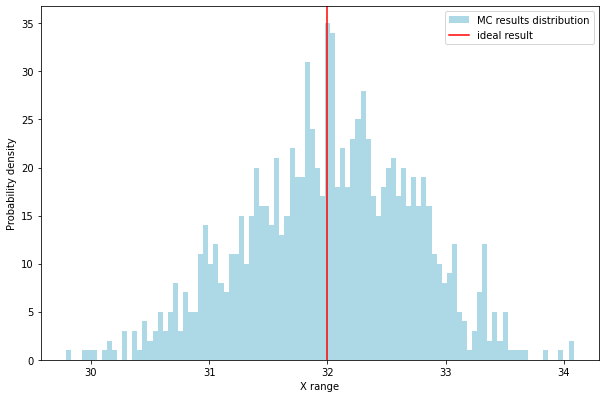

In [71]:
plt.figure(figsize = (10, 6.5))
plt.hist(results, 100, color = 'lightblue', label = 'MC results distribution');
plt.axvline(x = ideal_sol, color = 'r', label = 'ideal result')
plt.ylabel('Probability density')
plt.xlabel('X range');
plt.legend();

I now want to see the distribution for smaller Ns: I will change its value from 1000 to just 10 samples. 

In [72]:
small_N = 5

results_small_Ns = []

for i in range(0, n_times): 
    
    results_small_Ns.append(Monte_Carlo(sigma, small_N))

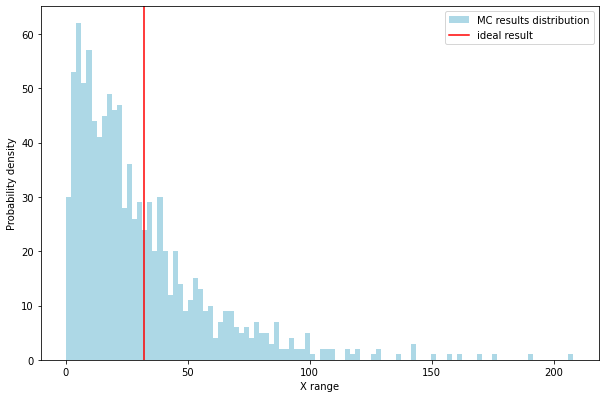

In [73]:
plt.figure(figsize = (10, 6.5))
plt.hist(results_small_Ns, 100, color = 'lightblue', label = 'MC results distribution');
plt.axvline(x = ideal_sol, color = 'r', label = 'ideal result')
plt.ylabel('Probability density')
plt.xlabel('X range');
plt.legend();

I see that the distribution with respect to the ideal solution is very different. 

## Multiple Ns solutions

Now I will plot some distributions at different Ns to see how they change as N changes:

In [61]:
Ns = [5, 30, 100, 1000, 10000]

results_ns = {}
error_ns = []

for ns in Ns: 
    
    results_ns[f"Ns = {ns}"] = []
    
    for i in range(0, n_times): 
    
        results_ns[f"Ns = {ns}"].append(Monte_Carlo(sigma, ns))

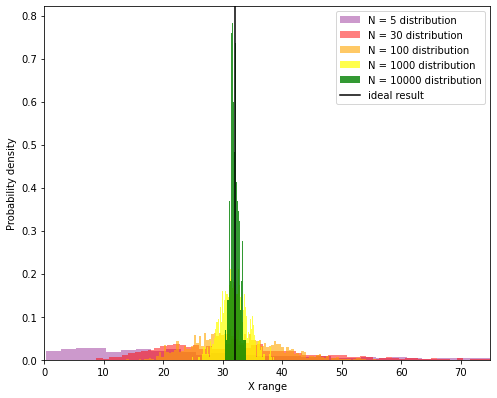

In [63]:
plt.figure(figsize = (8, 6.5))

plt.hist(results_ns["Ns = 5"], 100, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', color='purple', label='N = 5 distribution');
plt.hist(results_ns["Ns = 30"], 100, histtype='barstacked', density=True, alpha=0.5, edgecolor='none', color='red', label='N = 30 distribution');
plt.hist(results_ns["Ns = 100"], 100, histtype='barstacked', density=True, alpha=0.6, edgecolor='none', color='orange', label='N = 100 distribution');
plt.hist(results_ns["Ns = 1000"], 100, histtype='barstacked', density=True, alpha=0.7, edgecolor='none', color='yellow', label='N = 1000 distribution');
plt.hist(results_ns["Ns = 10000"], 100, histtype='barstacked', density=True, alpha=0.8, edgecolor='none', color='green', label='N = 10000 distribution');

plt.axvline(x = ideal_sol, color = 'black', label = 'ideal result')

plt.xlim(0, 75)

plt.ylabel('Probability density')
plt.xlabel('X range');
plt.legend()

I see that gradually the function gets narrower and sharper as N is increased. The peak is also shown to be centered more and more into the "ideal" solution, meaning that increasing the number of samples for the integration returns a better estimate of the result. 

### Errors

To see how the error scales, I'd like to extend this calculation to a Ns-array whose size is >>> 5. 

In [9]:
Ns_long = np.logspace(0,6,100,dtype=int)

I will not produce the distributions for each Ns_i (diven n_times attempts to extract the value), instead I will extract the value for each $\textit{Ns_i}$ and the associated error. 

In [19]:
# the tqdm element was taken from solutions because I wanted to see the % bar

results_long = [Monte_Carlo(sigma, ns) for ns in tqdm(Ns_long)]  
errors_long = [np.abs(result - ideal_sol) for result in results_long]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 156.80it/s]


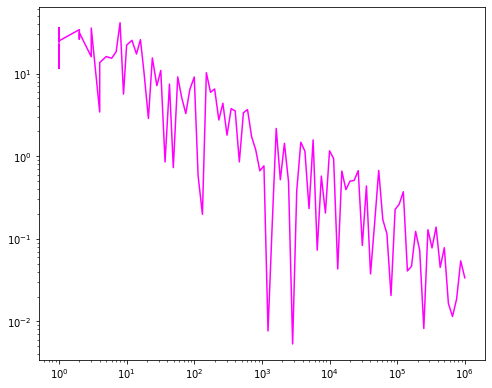

In [21]:
plt.figure(figsize = (8, 6.5))
plt.loglog(Ns_long, errors_long, c = 'magenta')

Hypothesis: the error goes as $\frac{sol_{ideal}}{\sqrt(N_i)}$, where $sol_{ideal}$ is the ideal solution. I try to see if it fits: 

In [48]:
def one_over_N(N_i):
    
    return [ideal_sol / np.sqrt(i) for i in N_i]

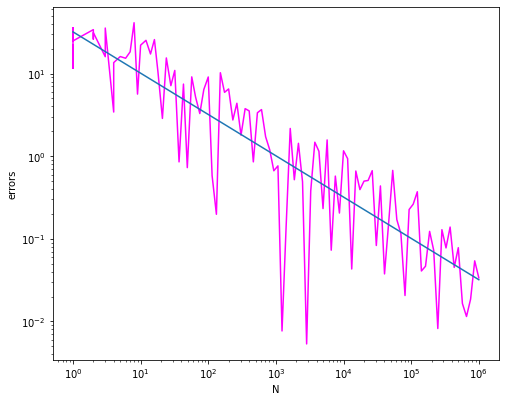

In [51]:
plt.figure(figsize = (8, 6.5))
plt.loglog(Ns_long, errors_long, c = 'magenta')
plt.loglog(Ns_long, one_over_N(Ns_long))
plt.xlabel('N')
plt.ylabel('errors')
plt.plot();

### Large Ns distribution

I will now try to fit the result at $N = 10000$ with a normal distribution whose error I will estimate using the percentiles.

In [64]:
# error estimate: 

sigma_x = (np.percentile(results_ns["Ns = 10000"], 84.1) - np.percentile(results_ns["Ns = 10000"], 15.9)) / 2

In [65]:
x_i = np.linspace(20, 50, 10000)

norm_distr = norm.pdf(x_i, loc=ideal_sol, scale=sigma_x)

I need to fit the $\textbf{normalized}$ results with the normal distribution I can generate:

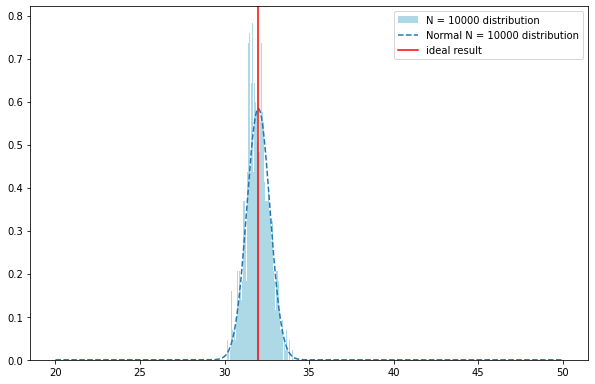

In [66]:
# plotting results and estimate: 

plt.figure(figsize = (10, 6.5))

plt.hist(results_ns["Ns = 10000"], 100, color = 'lightblue', label = 'N = 10000 distribution', density = 'True');
plt.plot(x_i, norm_distr, color='C0', ls='--', label='Normal N = 10000 distribution')
plt.axvline(x = ideal_sol, color = 'r', label = 'ideal result')
plt.legend()

Is it a Gaussian? My hypothesis is that the distribution is not Gaussian for small $\textit{Ns}$ and then becomes a Gaussian in the limit for large $\textit{Ns}$. 